## MNIST CNN

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *

### Data

In [7]:
path = untar_data(URLs.MNIST)

In [8]:
path.ls()

[WindowsPath('C:/Users/georg/.fastai/data/mnist_png/testing'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training')]

In [9]:
il = ImageList.from_folder(path, convert_mode='L')

In [10]:
il.items[0]

WindowsPath('C:/Users/georg/.fastai/data/mnist_png/testing/0/10.png')

In [11]:
defaults.cmap='binary'

In [12]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\georg\.fastai\data\mnist_png

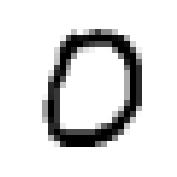

In [13]:
il[0].show()

In [14]:
sd = il.split_by_folder(train='training', valid='testing')

In [15]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\georg\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\georg\.fastai\data\mnist_png;

Test: None

In [16]:
(path/'training').ls()

[WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/0'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/1'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/2'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/3'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/4'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/5'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/6'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/7'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/8'),
 WindowsPath('C:/Users/georg/.fastai/data/mnist_png/training/9')]

In [17]:
ll = sd.label_from_folder()

In [18]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\georg\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\georg\.fastai\data\mnist_png;

Test: None

In [19]:
x,y = ll.train[0]

0 torch.Size([1, 28, 28])


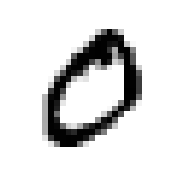

In [20]:
x.show()
print(y,x.shape)

In [22]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [23]:
ll = ll.transform(tfms)

In [24]:
bs = 128

In [25]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [26]:
x,y = data.train_ds[0]

0


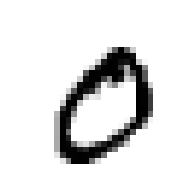

In [27]:
x.show()
print(y)

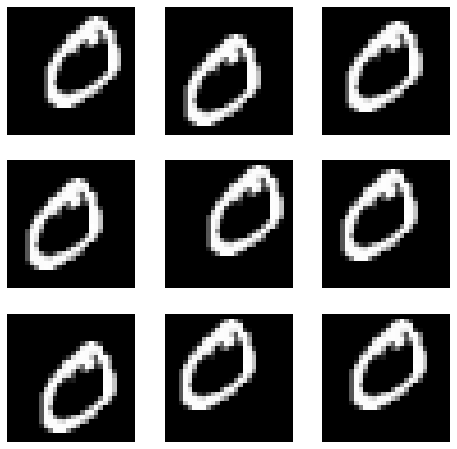

In [28]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [29]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

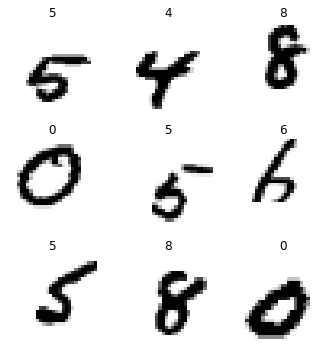

In [30]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [31]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [32]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [33]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [34]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [35]:
xb = xb.cuda()

In [36]:
model(xb).shape

torch.Size([128, 10])

In [37]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


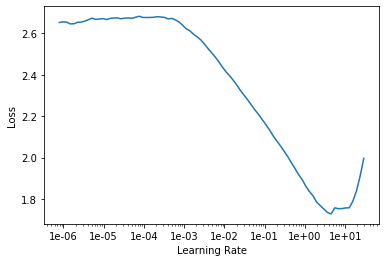

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.228335,0.119419,0.961400,01:58
1,0.130692,0.076077,0.976300,01:58
2,0.068206,0.039585,0.987600,01:28


### Refactor

In [40]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [ ]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.228332,0.206325,0.937500
2,0.189966,0.192558,0.940800
3,0.156765,0.092810,0.969100
4,0.135871,0.083914,0.973300
5,0.108844,0.071582,0.978000
6,0.105887,0.128586,0.960200
7,0.080699,0.052754,0.983200
8,0.066007,0.037588,0.988600
9,0.047513,0.030255,0.990200
10,0.044705,0.028373,0.991600


### Resnet-ish

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [ ]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


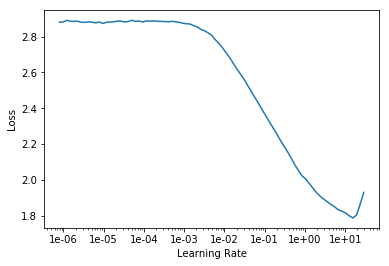

In [ ]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.248807,0.121582,0.972800
2,0.120927,0.360583,0.890300
3,0.104013,0.074916,0.977800
4,0.081181,0.065717,0.980000
5,0.068514,0.096448,0.967200
6,0.061274,0.087955,0.971800
7,0.051673,0.033911,0.989400
8,0.048090,0.033234,0.988800
9,0.039095,0.024638,0.992400
10,0.023670,0.021215,0.993400


In [ ]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin